# Resolved a sudoku thanks to CSP

Imports

In [13]:
import time
from collections import deque
import random
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import copy

## Let's create the game and rules

Create the problem FIND A WAY TO DETERMINE AUTOMATICALLY THE MIN SLOTS NEEDED

In [14]:
# Easy version: 10 teams, 10 time slots 
easy_teams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'] 
easy_time_slots = [i for i in range(0,15)]  # Slot1 = 1, Slot2 = 2, ..., Slot10 = 10
easy_matches = [(easy_teams[i], easy_teams[j]) for i in range(len(easy_teams)) for j in range(i+1, len(easy_teams))]  # All possible matches
# Medium version: 20 teams, 15 time slots, no two matches in a row for each team
medium_teams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
medium_time_slots = [i for i in range(0,30)]  
medium_matches = [(medium_teams[i], medium_teams[j]) for i in range(len(medium_teams)) for j in range(i+1, len(medium_teams))]  # All possible matches

# Hard version: 20 teams, 20 time slots, no two matches in a row for each team, two venues
hard_teams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
hard_time_slots = [i for i in range(0,30)]  # Slot1 = 1, Slot2 = 2, ..., Slot20 = 20
hard_venues = ["Venue1", "Venue2"]
hard_matches = [(hard_teams[i], hard_teams[j]) for i in range(len(hard_teams)) for j in range(i+1, len(hard_teams))]  # All possible matches

Now check if its valid

In [15]:
#this function will check if the match is valid or not for each difficulty level
#assigments = {('A', 'B'): (1,'Venue1')}.....}
def is_valid(match, slot, assignments, version, venue=None):
    match = tuple(sorted(match))
    team1, team2 = match
    
    for other_match, (other_slot, other_venue) in assignments.items():
        other_match = tuple(sorted(other_match)) #important to sort the match
        other_team1, other_team2 = other_match
        
        if other_match != match: #if the same match it's obviously invalid
            if version == "easy": #check if the slot is the same and if the teams are the same
                if slot == other_slot and (team1 == other_team1 or team1 == other_team2 or team2 == other_team1 or team2 == other_team2):
                    return False
                
            if version == "medium":
                nb_slot = len(medium_time_slots)
                if slot == other_slot and (team1 == other_team1 or team1 == other_team2 or team2 == other_team1 or team2 == other_team2):
                    return False #same check as easy with the addition of the slot check before and after in order to avoid the consecutive matches
                if (slot >=1 or slot<=nb_slot) and (slot - 1 == other_slot or slot + 1 == other_slot) and (team1 == other_team1 or team1 == other_team2 or team2 == other_team1 or team2 == other_team2):
                    return False
            
            if version == "hard":
                nb_slot = len(hard_time_slots)
                if slot == other_slot and (team1 == other_team1 or team1 == other_team2 or team2 == other_team1 or team2 == other_team2):
                    return False
                if (slot >= 1 or slot<= nb_slot) and (slot - 1 == other_slot or slot + 1 == other_slot) and (team1 == other_team1 or team1 == other_team2 or team2 == other_team1 or team2 == other_team2):
                    return False #same check as medium with the addition of the venue check 
                if slot == other_slot and venue == other_venue:
                    return False
    return True
#generate the assignment for each difficulty level
def generate_assignment(version):
    assigments = {}
    if version == "easy":
        matches = easy_matches
        for match in matches:
            assigments[match] = ("Not Defined","No Venue")
    if version == "medium":
        matches = medium_matches        
        for match in matches:
            assigments[match] = ("Not Defined","No Venue")
    if version == "hard":
        matches = hard_matches
        for match in matches:
            assigments[match] = ("Not Defined","Not Defined")
        
    return assigments
 
    

check if its completed for backtracking technics

In [16]:
def is_completed(asssignments):
    for match, (slot,venue) in asssignments.items():
        if slot == "Not Defined" or venue == "Not Defined": #if each match has a slot and a venue then it's completed 
            return False
    return True
test = generate_assignment("easy")
print(is_completed(test))

False


print

In [17]:
def print_schedule(assignments, version): #a function to print the schedule in a more readable way for debugging
    if version == "easy":
        print("Match\tSlot")
        for match, (slot,venue) in assignments.items():
            print(f"{match}\t{slot}")
    if version == "medium":
        print("Match\tSlot")
        for match, (slot,venue) in assignments.items():
            print(f"{match}\t{slot}")
    if version == "hard":
        print("Match\tSlot\tVenue")
        for match, (slot,venue) in assignments.items():
            print(f"{match}\t{slot}\t{venue}")
            

## Let's start CSP

Backtracking solution baseline

In [18]:
def backtracking(assignments, version, iter=0):
    if is_completed(assignments):
        return iter, True, assignments
    
    matches = list(assignments.keys()) #list of matches
    
    for match in matches:
        if assignments[match][0] == "Not Defined": # Check if the match is not assigned
            if version == "easy":
                slots = easy_time_slots
            elif version == "medium":
                slots = medium_time_slots
            elif version == "hard":
                slots = hard_time_slots
                venues = hard_venues
            
            for slot in slots:
                if version == "hard": #if hard check the venues too
                    for venue in venues:
                        if is_valid(match, slot, assignments, version, venue):
                            assignments[match] = (slot, venue)
                            iter, result, assignments = backtracking(assignments, version, iter + 1)
                            if result:
                                return iter, True, assignments
                            assignments[match] = ("Not Defined", "Not Defined")
                else: #else just check the slots
                    if is_valid(match, slot, assignments, version):
                        assignments[match] = (slot, "No Venue")
                        iter, result, assignments = backtracking(assignments, version, iter + 1)
                        if result:
                            return iter, True, assignments
                        assignments[match] = ("Not Defined", "No Venue")
    return iter, False, assignments

##  Reduction

init domain

In [19]:
def init_domains(version): #generate the domains for each difficulty level the only difference is for the hard level where we have to add the venues
    domains = {}
    if version == "easy":
        matches = easy_matches
        slots = easy_time_slots
        for match in matches:
            domains[match] = slots[:]
    elif version == "medium":
        matches = medium_matches
        slots = medium_time_slots
        for match in matches:
            domains[match] = slots[:]
    elif version == "hard":
        matches = hard_matches
        slots = hard_time_slots
        venues = hard_venues
        for match in matches:
            domains[match] = [(slot, venue) for slot in slots for venue in venues]
    return domains


def remove_inconsistent_values(domains, match, version): #remove the inconsistent values from the domains for each difficulty level
    removed = False
    if len(domains[match]) == 1:
        value = domains[match][0]
        for neighbor in domains:
            if neighbor != match:
                if version == "easy" or version == "medium":
                    if value in domains[neighbor]:
                        domains[neighbor].remove(value)
                        removed = True
                elif version == "hard":
                    domains[neighbor] = [(s, v) for s, v in domains[neighbor] if s != value[0] or v != value[1]]
                    removed = True
    return removed


First method for problem reduction :  Forward checking

In [20]:
def forward_checking(assignments, version, domains):
    new_domains = copy.deepcopy(domains)
    for match, (slot, venue) in assignments.items():
        if slot != "Not Defined":
            for other_match in new_domains:
                if other_match != match:
                    if version == "easy" or version == "medium":
                        if slot in new_domains[other_match]:
                            new_domains[other_match].remove(slot)
                    elif version == "hard":
                        new_domains[other_match] = [(s, v) for s, v in new_domains[other_match] if s != slot or v != venue]
    return new_domains

def backtracking_with_forward_checking(assignments, version, domains=None, iter=0):
    if domains is None:
        domains = init_domains(version)
        domains = forward_checking(assignments, version, domains)
        if not domains:  # Forward checking preprocessing; fails if any domain becomes empty
            return iter, False, assignments

    if is_completed(assignments):
        return iter, True, assignments
    
    matches = list(assignments.keys())
    
    for match in matches:
        if assignments[match][0] == "Not Defined":
            if version == "easy":
                for slot in domains[match]:
                    if is_valid(match, slot, assignments, version):
                        assignments[match] = (slot, "No Venue")
                        new_domains = forward_checking(assignments, version, domains)
                        next_iter, result, assignments = backtracking_with_forward_checking(assignments, version, new_domains, iter + 1)
                        if result:
                            return next_iter, True, assignments
                        assignments[match] = ("Not Defined", "No Venue")
            elif version == "medium":
                for slot in domains[match]:
                    if is_valid(match, slot, assignments, version):
                        assignments[match] = (slot, "No Venue")
                        new_domains = forward_checking(assignments, version, domains)
                        next_iter, result, assignments = backtracking_with_forward_checking(assignments, version, new_domains, iter + 1)
                        if result:
                            return next_iter, True, assignments
                        assignments[match] = ("Not Defined", "No Venue")
            elif version == "hard":
                for slot, venue in domains[match]:
                    if is_valid(match, slot, assignments, version, venue):
                        assignments[match] = (slot, venue)
                        new_domains = forward_checking(assignments, version, domains)
                        next_iter, result, assignments = backtracking_with_forward_checking(assignments, version, new_domains, iter + 1)
                        if result:
                            return next_iter, True, assignments
                        assignments[match] = ("Not Defined", "Not Defined")
            break  # Exit the loop after processing the first unassigned match
    return iter, False, assignments



Second method for problem reduction :  AC-3

In [21]:

def ac3(domains, version): #
    queue = deque([(match, neighbor) for match in domains for neighbor in domains if neighbor != match])
    while queue:  #create the queue with all the domains between the matches
        (match, neighbor) = queue.popleft()
        if remove_inconsistent_values(domains, match, version):
            if not domains[match]:  # Empty domain means fail/error
                return False
            for neighbor in domains:
                if neighbor != match:
                    queue.append((neighbor, match))
    return domains


def backtracking_with_ac3(assignments, version, domains=None, iter=0):
    if domains is None:
        domains = init_domains(version)
        domains = ac3(domains, version)
        if not domains:  # AC-3 preprocessing; fails if any domain becomes empty
            return iter, False, assignments

    if is_completed(assignments):
        return iter, True, assignments
    
    matches = list(assignments.keys())
    #same structure as the simple backtraclkign function but we add the ac3 step
    for match in matches:
        if assignments[match][0] == "Not Defined":
            if version == "easy":
                for slot in domains[match]:
                    if is_valid(match, slot, assignments, version):
                        assignments[match] = (slot, "No Venue")
                        next_iter, result, assignments = backtracking_with_ac3(assignments, version, domains, iter + 1)
                        if result:
                            return next_iter, True, assignments
                        assignments[match] = ("Not Defined", "No Venue")
            elif version == "medium":
                for slot in domains[match]:
                    if is_valid(match, slot, assignments, version):
                        assignments[match] = (slot, "No Venue")
                        next_iter, result, assignments = backtracking_with_ac3(assignments, version, domains, iter + 1)
                        if result:
                            return next_iter, True, assignments
                        assignments[match] = ("Not Defined", "No Venue")
            elif version == "hard":
                for slot, venue in domains[match]:
                    if is_valid(match, slot, assignments, version, venue):
                        assignments[match] = (slot, venue)
                        next_iter, result, assignments = backtracking_with_ac3(assignments, version, domains, iter + 1)
                        if result:
                            return next_iter, True, assignments
                        assignments[match] = ("Not Defined", "Not Defined")
            break  # Exit the loop after processing the first unassigned match
    return iter, False, assignments




## A basic search strategy and a Stochastic search method 

Hill Climb

In [22]:
#hill climb solution need to generate a first random solution (adapt to the difficulty level)
def generate_solution(version):
    assignments = generate_assignment(version)
    if version == "easy":
        slots = easy_time_slots
        for match in assignments:
            match = tuple(sorted(match))
            slot = random.choice(slots)
            assignments[match] = (slot, "No Venue")
    elif version == "medium":
        slots = medium_time_slots
        for match in assignments:
            match = tuple(sorted(match))
            slot = random.choice(slots)
            assignments[match] = (slot, "No Venue")
    elif version == "hard":
        slots = hard_time_slots
        venues = hard_venues
        for match in assignments:
            match = tuple(sorted(match))
            slot = random.choice(slots)
            venue = random.choice(venues)
            assignments[match] = (slot, venue)
            
    return assignments

#the cost function determines the number of constraints violated

#is_valid function but for hill climb
    

def cost(assignments,version):
    cost = 0
    for match, (slot,venue) in assignments.items():
        if not is_valid(match,slot,assignments,version,venue): #for each match if he is not valid so we add 1 to the cost
            cost += 1
    return cost

#switch the slot of two matches function 
def switch_slots(assignments, match1, match2):
    assignments[match1], assignments[match2] = assignments[match2], assignments[match1]
    return assignments

#switch the venue of two matches function
def switch_venue(assignments, match1, match2):
    slot1, venue1 = assignments[match1]
    slot2, venue2 = assignments[match2]
    assignments[match1] = (slot1, venue2)
    assignments[match2] = (slot2, venue1)    #Keep the same slot (important)
    return assignments

#hill climb algorithm

def hill_climb(version, max_iter,random_moov):
    current_solution = generate_solution(version)
    current_cost = cost(current_solution, version)
    
    for iter in range(max_iter):
        #choose two random match
        match1, match2 = random.sample(list(current_solution.keys()), 2)
        if version == "hard":
            #switch venue or the slot random
            v_or_s = random.choice(["venue", "slot"])
            if v_or_s == "slot":
                new_solution = switch_slots(current_solution, match1, match2)
            else:
                new_solution = switch_venue(current_solution, match1, match2)            
            
            new_cost = cost(new_solution, version)
            if new_cost < current_cost or random.random() < random_moov: #if the new cost is better or we choose to move randomly (avoiding local extremum)
                current_solution = new_solution
                current_cost = new_cost
        else:
            #switch only the slot
            new_solution = switch_slots(current_solution, match1, match2)
            new_cost = cost(new_solution, version)
            if (new_cost < current_cost) or (random.random() < random_moov):
                current_solution = new_solution
                current_cost = new_cost
        if current_cost == 0:
            return iter, True, current_solution
        
    return iter,False,current_solution
    

Graph reprensentation with simple backtracking

{('A', 'B'): {('A', 'D'), ('B', 'G'), ('A', 'E'), ('B', 'I'), ('A', 'C'), ('A', 'H'), ('A', 'J'), ('B', 'E'), ('B', 'F'), ('B', 'C'), ('B', 'D'), ('B', 'H'), ('B', 'J'), ('A', 'F'), ('A', 'I'), ('A', 'G')}, ('A', 'C'): {('C', 'G'), ('A', 'D'), ('A', 'E'), ('C', 'I'), ('A', 'B'), ('C', 'E'), ('C', 'F'), ('A', 'J'), ('A', 'H'), ('C', 'D'), ('C', 'H'), ('C', 'J'), ('B', 'C'), ('A', 'F'), ('A', 'I'), ('A', 'G')}, ('A', 'D'): {('A', 'E'), ('A', 'B'), ('A', 'C'), ('A', 'H'), ('A', 'J'), ('C', 'D'), ('D', 'G'), ('B', 'D'), ('D', 'I'), ('D', 'E'), ('D', 'F'), ('D', 'J'), ('D', 'H'), ('A', 'F'), ('A', 'I'), ('A', 'G')}, ('A', 'E'): {('A', 'D'), ('E', 'G'), ('A', 'B'), ('C', 'E'), ('E', 'I'), ('A', 'C'), ('A', 'H'), ('A', 'J'), ('B', 'E'), ('E', 'F'), ('E', 'J'), ('E', 'H'), ('D', 'E'), ('A', 'F'), ('A', 'I'), ('A', 'G')}, ('A', 'F'): {('F', 'J'), ('F', 'H'), ('A', 'D'), ('A', 'E'), ('A', 'B'), ('C', 'F'), ('A', 'C'), ('A', 'H'), ('A', 'J'), ('B', 'F'), ('E', 'F'), ('D', 'F'), ('F', 'G'), ('F', 

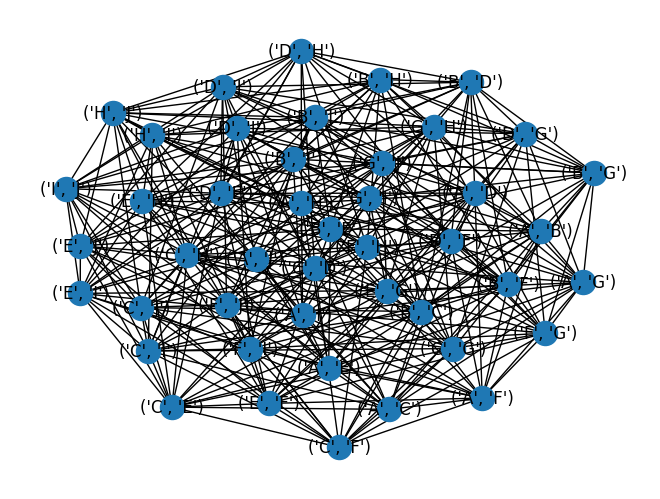

45 True
Match	Slot
('A', 'B')	0
('A', 'C')	1
('A', 'D')	2
('A', 'E')	3
('A', 'F')	4
('A', 'G')	5
('A', 'H')	6
('A', 'I')	7
('A', 'J')	8
('B', 'C')	2
('B', 'D')	1
('B', 'E')	4
('B', 'F')	3
('B', 'G')	6
('B', 'H')	5
('B', 'I')	8
('B', 'J')	7
('C', 'D')	0
('C', 'E')	5
('C', 'F')	6
('C', 'G')	3
('C', 'H')	4
('C', 'I')	9
('C', 'J')	10
('D', 'E')	6
('D', 'F')	5
('D', 'G')	4
('D', 'H')	3
('D', 'I')	10
('D', 'J')	9
('E', 'F')	0
('E', 'G')	1
('E', 'H')	2
('E', 'I')	11
('E', 'J')	12
('F', 'G')	2
('F', 'H')	1
('F', 'I')	12
('F', 'J')	11
('G', 'H')	0
('G', 'I')	13
('G', 'J')	14
('H', 'I')	14
('H', 'J')	13
('I', 'J')	0


In [23]:
def generate_the_graph(assignments, version):
    graph = {}
    matches = list(assignments.keys())
    
    for match in matches:
        match = tuple(sorted(match))
        graph[match] = set()
        team1, team2 = match
        
        for other_match in matches:
            if other_match != match:
                other_team1, other_team2 = other_match
                
                if version == "easy" or version == "medium":
                    # Add edge if teams overlap or if medium version and teams play in consecutive slots
                    if team1 in other_match or team2 in other_match:
                        graph[match].add(other_match)
                    if version == "medium":
                        graph[match].add(other_match)
                
                if version == "hard":
                    # Add edge if teams overlap or if teams play in consecutive slots or same venue
                    if team1 in other_match or team2 in other_match:
                        graph[match].add(other_match)
                    graph[match].add(other_match)
    
    return graph

assignments = generate_assignment("easy")
graph = generate_the_graph(assignments, "easy")
print(graph)

def plot_graph(graph):
    #plot the graph using matplotlib and networkx
    G = nx.Graph()
    for node, neighbors in graph.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)
    nx.draw(G, with_labels=True)
    plt.show()
    
plot_graph(graph)


#new is_valid function for the graph
def is_valid_graph(graph, node, assignments, version):
    team1, team2 = node
    slot, venue = assignments[node]
    
    for neighbor in graph[node]:
        neighbor_slot, neighbor_venue = assignments[neighbor]
        neighbor_team1, neighbor_team2 = neighbor
        
        if neighbor_slot != "Not Defined":
            if version == "easy":
                if slot == neighbor_slot and (team1 == neighbor_team1 or team1 == neighbor_team2 or team2 == neighbor_team1 or team2 == neighbor_team2):
                    return False
                
            if version == "medium":
                if slot == neighbor_slot and (team1 == neighbor_team1 or team1 == neighbor_team2 or team2 == neighbor_team1 or team2 == neighbor_team2):
                    return False
                if slot >= 1 and slot - 1 == neighbor_slot and (team1 == neighbor_team1 or team1 == neighbor_team2 or team2 == neighbor_team1 or team2 == neighbor_team2):
                    return False
                if slot <= len(medium_time_slots) and slot + 1 == neighbor_slot and (team1 == neighbor_team1 or team1 == neighbor_team2 or team2 == neighbor_team1 or team2 == neighbor_team2):
                    return False
            
            if version == "hard":
                if slot == neighbor_slot and (team1 == neighbor_team1 or team1 == neighbor_team2 or team2 == neighbor_team1 or team2 == neighbor_team2):
                    return False
                if slot >= 1 and slot - 1 == neighbor_slot and (team1 == neighbor_team1 or team1 == neighbor_team2 or team2 == neighbor_team1 or team2 == neighbor_team2):
                    return False
                if slot <= len(hard_time_slots) and slot + 1 == neighbor_slot and (team1 == neighbor_team1 or team1 == neighbor_team2 or team2 == neighbor_team1 or team2 == neighbor_team2):
                    return False
                if slot == neighbor_slot and venue == neighbor_venue:
                    return False
    return True

def solve_using_graph_backtracking(assignments, graph, version, iter=0): #the idea is the same as without graph
    if is_completed(assignments):
        return iter, True, assignments
    
    matches = list(assignments.keys())
    
    for match in matches:
        if assignments[match][0] == "Not Defined":
            if version == "easy":
                slots = easy_time_slots
            elif version == "medium":
                slots = medium_time_slots
            elif version == "hard":
                slots = hard_time_slots
                venues = hard_venues
            
            for slot in slots:
                if version == "hard":
                    for venue in venues:
                        assignments[match] = (slot, venue)
                        if is_valid_graph(graph, match, assignments, version): #the us of the is_valid_graph is the keypoint
                            iter, result, assignments = solve_using_graph_backtracking(assignments, graph, version, iter + 1)
                            if result:
                                return iter, True, assignments
                            assignments[match] = ("Not Defined", "Not Defined")
                else:
                    assignments[match] = (slot, "No Venue")
                    if is_valid_graph(graph, match, assignments, version):
                        iter, result, assignments = solve_using_graph_backtracking(assignments, graph, version, iter + 1)
                        if result:
                            return iter, True, assignments
                        assignments[match] = ("Not Defined", "No Venue")
    return iter, False, assignments

assignments = generate_assignment("easy")
graph = generate_the_graph(assignments, "easy")
iter, result, assignments = solve_using_graph_backtracking(assignments, graph, "easy")
print(iter, result)
print_schedule(assignments, "easy")

## Function(s) in order to compare the efficacity of each method

time and iterations

In [ ]:
def measure_time_and_iterations(func,*args):
    start_time = time.time()
    iterations = func(*args)[0]
    succeed = func(*args)[1]
    end_time = time.time()
    executive_time = end_time - start_time
    return executive_time, iterations, succeed

def testing(n):
    difficulties = ["hard"]
    diff_results ={}
    for difficulty in difficulties:
        methods= ['backtracking_with_forward_checking','simple_backtracking','ac3_backtracking','graph','hill_climb']
        #a dict with the results of each method for the n test
        results = {}
        
        for  method in methods:
            
            assignments = generate_assignment(difficulty)
            if method == 'simple_backtracking':
                
                time_values =[]
                iter_values = []
                
                for _ in range(0,n):
                    time_iter = measure_time_and_iterations(backtracking,assignments,difficulty)
                    is_solved = time_iter[2]
                    if is_solved:
                        
                        time_values.append(time_iter[0])
                        iter_values.append(time_iter[1])

                if len(time_values) == 0:
                    results[method] = "No result found"
                    print(f"No result found for the {difficulty} difficulty with the {method} method")
                else:    
                    time_mean = sum(time_values)/len(time_values)
                    iter_mean = sum(iter_values)/len(iter_values)
                    results[method] = [time_mean,iter_mean,is_solved]
                    print(f"The simple version take a mean value of: {time_mean} seconds and a mean value of: {iter_mean} iterations to solve the match problem for {n} tests for the {difficulty} version")
            elif method == 'backtracking_with_forward_checking':
                domains = init_domains(difficulty)
                
                time_values =[]
                iter_values = []
                
                for _ in range(0,n):
                    time_iter = measure_time_and_iterations(backtracking_with_forward_checking,assignments,difficulty,domains)
                    is_solved = time_iter[2]
                    if is_solved:
                        
                        time_values.append(time_iter[0])
                        iter_values.append(time_iter[1])

                if len(time_values) == 0:
                    results[method] = "No result found"
                    print(f"No result found for the {difficulty} difficulty with the {method} method")
                else:    
                    time_mean = sum(time_values)/len(time_values)
                    iter_mean = sum(iter_values)/len(iter_values)
                    results[method] = [time_mean,iter_mean,is_solved]
                    print(f"The backtracking_with_forward_checking version take a mean value of: {time_mean} seconds and a mean value of: {iter_mean} iterations to solve the match problem for {n} tests for the {difficulty} version")
            elif method == 'ac3_backtracking':
                domains = init_domains(difficulty)
                
                time_values =[]
                iter_values = []
                
                for _ in range(0,n):
                    time_iter = measure_time_and_iterations(backtracking_with_ac3,assignments,difficulty,domains)
                    is_solved = time_iter[2]
                    if is_solved:
                        
                        time_values.append(time_iter[0])
                        iter_values.append(time_iter[1])

                if len(time_values) == 0:
                    results[method] = "No result found"
                    print(f"No result found for the {difficulty} difficulty with the {method} method")
                else:    
                    time_mean = sum(time_values)/len(time_values)
                    iter_mean = sum(iter_values)/len(iter_values)
                    results[method] = [time_mean,iter_mean,is_solved]
                    print(f"The ac3_backtracking version take a mean value of: {time_mean} seconds and a mean value of: {iter_mean} iterations to solve the match problem for {n} tests for the {difficulty} version")
            elif method == 'graph':
                domains = init_domains(difficulty)
                
                time_values =[]
                iter_values = []
                graph = generate_the_graph(assignments,difficulty)
                for _ in range(0,n):
                    time_iter = measure_time_and_iterations(solve_using_graph_backtracking,assignments,graph,difficulty)
                    is_solved = time_iter[2]
                    if is_solved:
                        
                        time_values.append(time_iter[0])
                        iter_values.append(time_iter[1])

                if len(time_values) == 0:
                    results[method] = "No result found"
                    print(f"No result found for the {difficulty} difficulty with the {method} method")
                else:    
                    time_mean = sum(time_values)/len(time_values)
                    iter_mean = sum(iter_values)/len(iter_values)
                    results[method] = [time_mean,iter_mean,is_solved]
                    print(f"The graph version take a mean value of: {time_mean} seconds and a mean value of: {iter_mean} iterations to solve the match problem for {n} tests for the {difficulty} version")
            elif method == 'hill_climb':
                
                time_values =[]
                iter_values = []
                for _ in range(0,n):
                    
                    time_iter = measure_time_and_iterations(hill_climb,difficulty,100000,0.1)
                    is_solved = time_iter[2]
                    if is_solved:
                        
                        time_values.append(time_iter[0])
                        iter_values.append(time_iter[1])

                if len(time_values) == 0:
                    results[method] = "No result found"
                    print(f"No result found for the {difficulty} difficulty with the {method} method")
                else:    
                    time_mean = sum(time_values)/len(time_values)
                    iter_mean = sum(iter_values)/len(iter_values)
                    results[method] = [time_mean,iter_mean,is_solved]
                    print(f"The hill_climb version take a mean value of: {time_mean} seconds and a mean value of: {iter_mean} iterations to solve the match problem for {n} tests for the {difficulty} version")
        print(results)
        diff_results[difficulty] = results
    df = pd.DataFrame(diff_results)
    df.to_csv('data/match_results.csv')
    return diff_results

testing(1)



The simple version take a mean value of: 0.006997108459472656 seconds and a mean value of: 45.0 iterations to solve the match problem for 1 tests for the hard version
The ac3_backtracking version take a mean value of: 0.007001638412475586 seconds and a mean value of: 45.0 iterations to solve the match problem for 1 tests for the hard version
The graph version take a mean value of: 0.005998134613037109 seconds and a mean value of: 45.0 iterations to solve the match problem for 1 tests for the hard version


KeyboardInterrupt: 